In [ ]:
# Slightly modified from Max's performance script
from https://github.com/maxnoe/test_ctapipe_ml/blob/main/performance.ipynb

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import operator
import numpy as np

from ctapipe.io import TableLoader

import astropy.units as u
from astropy.table import vstack, QTable
#from astropy.coordinates.angle_utilities import angular_separation
#from astropy.coordinates.angle_utilities import angular_separation
from astropy.coordinates.angles.utils import angular_separation

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.metrics import roc_auc_score, roc_curve

from pyirf.simulations import SimulatedEventsInfo
from pyirf.benchmarks import energy_bias_resolution, angular_resolution
from pyirf.cuts import evaluate_binned_cut, calculate_percentile_cut
from pyirf.sensitivity import calculate_sensitivity, estimate_background
from pyirf.spectral import (
    CRAB_HEGRA, PowerLaw, POINT_SOURCE_FLUX_UNIT, calculate_event_weights, IRFDOC_PROTON_SPECTRUM,
    CRAB_MAGIC_JHEAP2015, IRFDOC_ELECTRON_SPECTRUM
)
from pyirf.utils import cone_solid_angle
from pyirf.binning import create_bins_per_decade, create_histogram_table
from pyirf.irf import effective_area_per_energy_and_fov
from pyirf.cut_optimization import optimize_gh_cut

%matplotlib agg

/home/punch/miniconda3/envs/ctapipe_0.24/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams['figure.constrained_layout.use'] = True

In [4]:
obstime = 50 * u.hour
fov_offset_min = 0 * u.deg
fov_offset_max = 1 * u.deg
multiplicity_cut = 3

alpha = 0.2
sensitivity_bins = create_bins_per_decade(10**-1.9 * u.TeV, 10**1.9 * u.TeV)

In [5]:
STD_OR_RED = "red" # "std"
EVAL_PROTON_FILE=f"/scr/punch/CTA/Prod6/LaPalma/2025/proton_final_{STD_OR_RED}.dl2.h5"
EVAL_ELECTRON_FILE=f"/scr/punch/CTA/Prod6/LaPalma/2025/electron_final_{STD_OR_RED}.dl2.h5"
EVAL_GAMMA_FILE=f"/scr/punch/CTA/Prod6/LaPalma/2025/gamma_final_{STD_OR_RED}.dl2.h5"

In [6]:
tab = TableLoader(
    EVAL_GAMMA_FILE,
    dl2=True, simulated=True, dl1_parameters=False
    )

In [7]:
tab.h5file.root._v_attrs

/._v_attrs (AttributeSet), 35 attributes:
   [CLASS := np.str_('GROUP'),
    CTA ACTIVITY ID := np.str_('557a7fdb-bcdf-41e7-9520-e73f6c630ffb'),
    CTA ACTIVITY NAME := np.str_('ctapipe-merge'),
    CTA ACTIVITY SOFTWARE NAME := np.str_('ctapipe'),
    CTA ACTIVITY SOFTWARE VERSION := np.str_('0.24.0'),
    CTA ACTIVITY START TIME := np.str_('2025-06-15 06:48:23.846'),
    CTA ACTIVITY STOP TIME := np.str_('2025-06-15 06:48:27.104'),
    CTA ACTIVITY TYPE := np.str_('software'),
    CTA CONTACT EMAIL := np.str_('unknown'),
    CTA CONTACT NAME := np.str_(''),
    CTA CONTACT ORGANIZATION := np.str_('unknown'),
    CTA INSTRUMENT CLASS := np.str_('Other'),
    CTA INSTRUMENT ID := np.str_('LaPalma-prod6_1-11,14,19'),
    CTA INSTRUMENT SITE := np.str_('Other'),
    CTA INSTRUMENT SUBTYPE := np.str_('unspecified'),
    CTA INSTRUMENT TYPE := np.str_('unspecified'),
    CTA INSTRUMENT VERSION := np.str_('unspecified'),
    CTA PROCESS ID := np.str_('59'),
    CTA PROCESS SUBTYPE := np.st

In [8]:
tab.read_shower_distribution()

obs_id,hist_id,n_entries,bins_energy,bins_core_dist,histogram
,,,TeV,m,
int32,int64,int64,float64[121],float64[201],"float32[120,200]"
59,6,2000000,0.001 .. 1000.0,0.0 .. 3800.0,0.0 .. 0.0
60,6,2000000,0.001 .. 1000.0,0.0 .. 3800.0,0.0 .. 0.0
61,6,2000000,0.001 .. 1000.0,0.0 .. 3800.0,0.0 .. 0.0
62,6,2000000,0.001 .. 1000.0,0.0 .. 3800.0,0.0 .. 0.0
63,6,2000000,0.001 .. 1000.0,0.0 .. 3800.0,0.0 .. 0.0
64,6,2000000,0.001 .. 1000.0,0.0 .. 3800.0,0.0 .. 0.0
65,6,2000000,0.001 .. 1000.0,0.0 .. 3800.0,0.0 .. 0.0
66,6,2000000,0.001 .. 1000.0,0.0 .. 3800.0,0.0 .. 0.0


In [9]:
simu_configs = tab.read_simulation_configuration()

In [10]:
sum(simu_configs['n_showers']*simu_configs['shower_reuse'])

np.int64(20000000)

In [11]:
#opts = dict(load_dl2=True, load_simulated=True, load_dl1_parameters=False)
opts = dict(dl2=True, simulated=True, dl1_parameters=False)


particles = {
    "gammas": {"path": EVAL_GAMMA_FILE, 'target_spectrum': CRAB_HEGRA},
    "protons": {"path": EVAL_PROTON_FILE, 'target_spectrum': IRFDOC_PROTON_SPECTRUM},
    "electrons": {"path": EVAL_ELECTRON_FILE, "target_spectrum": IRFDOC_ELECTRON_SPECTRUM},
}


for name, p in particles.items():
    print(f"Reading {name}")
    with TableLoader(p['path'], **opts) as g_loader:
        
        p['events'] = QTable(g_loader.read_subarray_events(), copy=False)
        
        p['simulation_configuration'] = g_loader.read_simulation_configuration()
        # MP: Problem reading shower distribution, abandon n_showers
        #p['shower_distribution'] = g_loader.read_shower_distribution()
        p['simulated_events'] = SimulatedEventsInfo(
            # MP: Problem reading shower distribution, abandon n_showers
            #n_showers=p['shower_distribution']['histogram'].sum(),
            n_showers=sum(p['simulation_configuration']['n_showers']*
                          p['simulation_configuration']['shower_reuse']),
            energy_min=p['simulation_configuration']['energy_range_min'].quantity[0],
            energy_max=p['simulation_configuration']['energy_range_max'].quantity[0],
            max_impact=p['simulation_configuration']['max_scatter_range'].quantity[0],
            spectral_index=p['simulation_configuration']['spectral_index'][0],
            viewcone_min=p['simulation_configuration']['min_viewcone_radius'].quantity[0],
            viewcone_max=p['simulation_configuration']['max_viewcone_radius'].quantity[0],
        )
        p['simulated_spectrum'] =  PowerLaw.from_simulation(p['simulated_events'], obstime=obstime)
        
        # renames to "select" algorithm
        p["events"]["reco_energy"] = p["events"]["RandomForestRegressor_energy"]
        p["events"]["reco_alt"] = p["events"]["HillasReconstructor_alt"]
        p["events"]["reco_az"] = p["events"]["HillasReconstructor_az"]
        p["events"]["gh_score"] = p["events"]["RandomForestClassifier_prediction"]
        
        # derive some columns
        p["events"]["theta"] = angular_separation(
            p["events"]["HillasReconstructor_az"], p["events"]["HillasReconstructor_alt"],
            p["events"]["true_az"], p["events"]["true_alt"],
        )
        
        p["events"]['true_source_fov_offset'] = angular_separation(
            p["events"]["true_az"], p["events"]["true_alt"],
            0 * u.deg, 70 * u.deg,
        )
        
        p['events']['valid_dl2'] = (
            p['events']['HillasReconstructor_is_valid']
            & p['events']['RandomForestRegressor_is_valid']
            & p['events']['RandomForestClassifier_is_valid']
        )
        

        if name == 'gammas':
            # integrate in fov_offset min / max and select events
            p['events']['selected_fov'] = (
                (p['events']['true_source_fov_offset'] >= fov_offset_min)
                & (p['events']['true_source_fov_offset'] < fov_offset_max)
            )
                     
            p['simulated_spectrum_original'] = p['simulated_spectrum']
            p['simulated_spectrum'] = p['simulated_spectrum'].integrate_cone(fov_offset_min, fov_offset_max)
            

        p["events"]["weight"] =  calculate_event_weights(
            p["events"]["true_energy"],
            target_spectrum=p["target_spectrum"], 
            simulated_spectrum=p["simulated_spectrum"]
        )

        p["events"]["reco_source_fov_offset"] = angular_separation(
            p["events"]["reco_az"], p["events"]["reco_alt"],
            0 * u.deg, 70 * u.deg,
        )
        
        p["events"]["multiplicity"] = np.count_nonzero(p["events"]["HillasReconstructor_telescopes"], axis=1)
        
    print('done')

Reading gammas
done
Reading protons
done
Reading electrons
done


In [12]:
print({n: len(p['events']) for n, p in particles.items()})

{'gammas': 11754, 'protons': 21231, 'electrons': 19414}


In [13]:
events = vstack([p["events"] for n, p in particles.items() if n != "electrons"])
gammas = particles['gammas']['events']
protons = particles['protons']['events']
electrons = particles['electrons']['events']

In [14]:
fig, ax = plt.subplots()


ax.hist(gammas['multiplicity'], bins=np.arange(15) - 0.5, lw=2, edgecolor='w')
ax.set(
    xticks=np.arange(14),
    yscale='log',
)

None

## Gammaness Distributions

In [15]:
%matplotlib inline

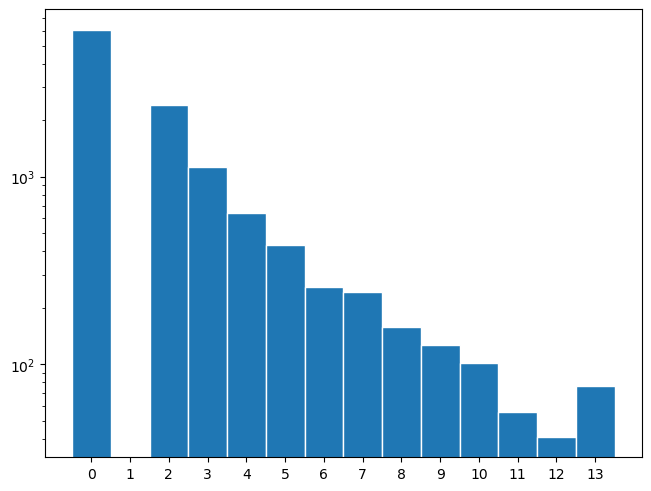

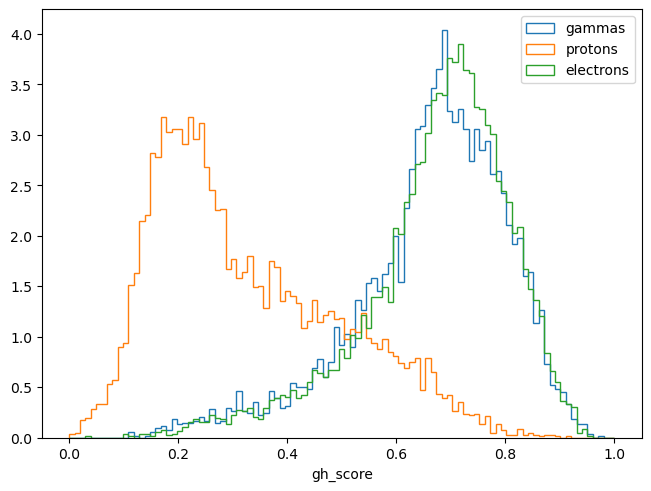

In [16]:
fig, ax = plt.subplots()

hist_opts = dict(bins=101, range=[0, 1], histtype='step', density=True)

key = "gh_score"
for label, t in particles.items():
    valid = t['events']['valid_dl2']
    plt.hist(t['events'][key][valid], **hist_opts, label=label)

ax.set_xlabel(key)
ax.legend()
plt.show()

Text(0.5, 0, 'gammaness')

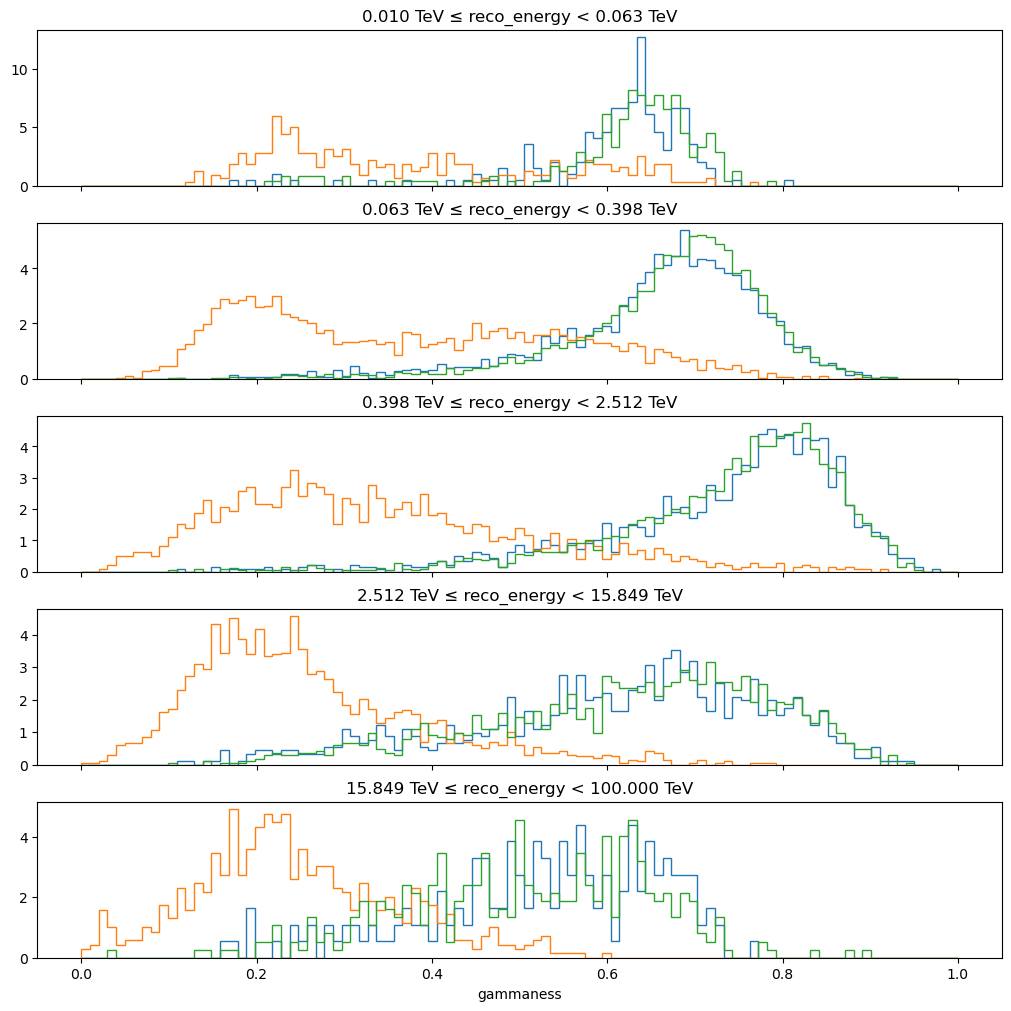

In [17]:
n_bins = 5
reco_energy_bins = np.geomspace(10 * u.GeV, 100 * u.TeV, n_bins + 1)


fig, axs = plt.subplots(
    len(reco_energy_bins) - 1, 1,
    figsize=(10, 2 * n_bins),
    sharex=True,
)

hist_opts = dict(bins=101, range=[0, 1], histtype='step', density=True)

key = "gh_score"

for label, p in particles.items():
    
    grouped = p['events'].group_by(np.digitize(p['events']['reco_energy'], reco_energy_bins))
    
    for idx, group  in zip(grouped.groups.keys, grouped.groups):
        # skip under / overflow
        if idx == 0 or idx == (n_bins + 1):
            continue
        
        idx -= 1
        ax = axs[idx]
        
        valid = group['valid_dl2']
        ax.hist(group[key][valid], **hist_opts, label=label)
        ax.set_title('{:.3f} ≤ reco_energy < {:.3f}'.format(reco_energy_bins[idx], reco_energy_bins[idx + 1]))
            
axs[-1].set_xlabel('gammaness')

## ROC-Curve

/tmp/ipykernel_770674/3018472538.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc = np.trapz(x=fpr, y=tpr)


[Text(0.5, 1.0, 'ROC AUC: 0.921'), None, (-0.01, 1.01), (-0.01, 1.01)]

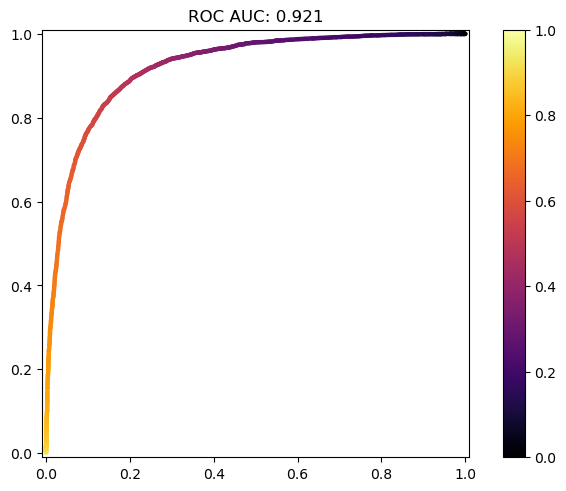

In [18]:
mask = events['valid_dl2']
fpr, tpr, threshold = roc_curve(
    events['true_shower_primary_id'][mask],
    # sklearn computes confusion matrix for each possible cut
    # much faster if rounded to 3 digits to reduce number of unique values
    np.round(events['RandomForestClassifier_prediction'][mask], 3), 
    pos_label=0,
)

roc_auc = np.trapz(x=fpr, y=tpr)


fig, ax = plt.subplots()

plot = ax.scatter(
    fpr, tpr,
    c=threshold,
    cmap='inferno',
    vmin=0,
    vmax=1,
    s=5,
)

fig.colorbar(plot, ax=ax)

ax.set(
    title=f'ROC AUC: {roc_auc:.3f}',
    aspect=1,
    xlim=(-0.01, 1.01),
    ylim=(-0.01, 1.01),
)

In [19]:
n_bins = 10
bins = np.geomspace(10 * u.GeV, 100 * u.TeV, n_bins + 1)

bin_index = np.digitize(events['reco_energy'].to_value(u.TeV), bins.to_value(u.TeV))
grouped = events.group_by(bin_index)

roc_curves = []
roc_aucs = np.full(n_bins, np.nan)
for idx, group  in zip(grouped.groups.keys, grouped.groups):
    
    # ignore under / overflow
    if idx == 0 or idx == n_bins + 1:
        continue
        
    mask = group["RandomForestClassifier_is_valid"]
    fpr, tpr, threshold = roc_curve(
        group['true_shower_primary_id'][mask],
        np.round(group['RandomForestClassifier_prediction'][mask], 3), 
        pos_label=0,
    )

    roc_curves.append((fpr, tpr, threshold))
    roc_aucs[idx - 1] = np.trapezoid(y=tpr, x=fpr)

[None, (0.0, 1.01), Text(0, 0.5, 'ROC Auc'), Text(0.5, 0, 'reco_energy / GeV')]

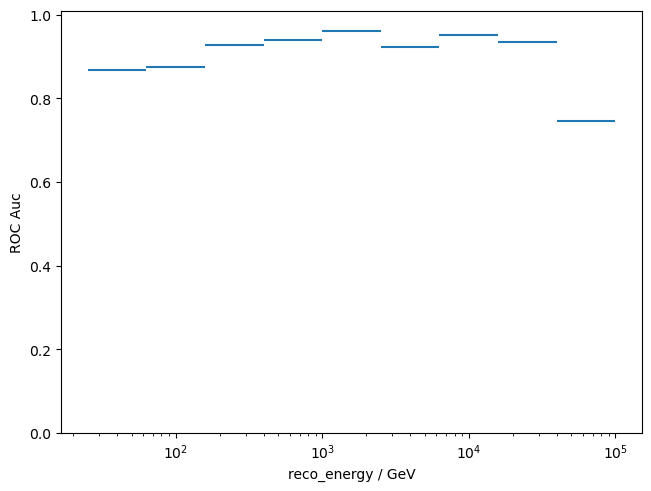

In [20]:
fig, ax = plt.subplots()

center = 0.5 * (bins[1:] + bins[:-1])
width = 0.5 * np.diff(bins) 

ax.errorbar(
    center.to_value(u.GeV),
    roc_aucs,
    xerr=width.to_value(u.GeV),
    ls='',
)

ax.set(
    xscale='log',
    ylim=(0, 1.01),
    ylabel='ROC Auc',
    xlabel='reco_energy / GeV'
)

(-0.05, 1.05)

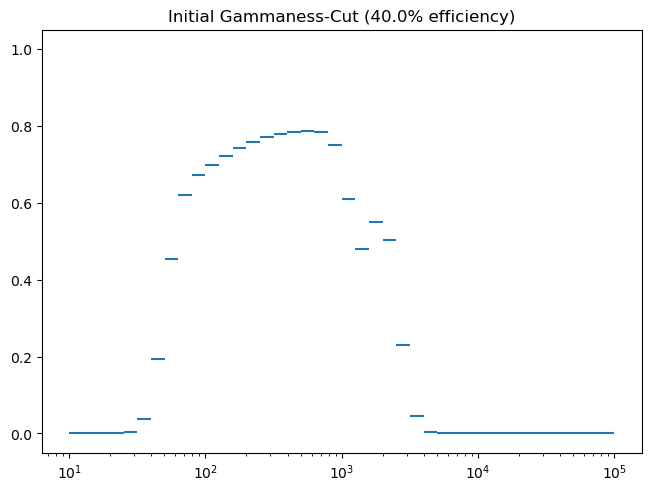

In [21]:
n_bins = 40
bins = np.geomspace(10 * u.GeV, 100 * u.TeV, n_bins + 1)


initial_gh_cut_efficiency = 0.4

selection = gammas['valid_dl2'] & gammas['selected_fov'] & (gammas["multiplicity"] >= multiplicity_cut)


initial_gh_cuts = calculate_percentile_cut(
    gammas['gh_score'][selection],
    gammas['reco_energy'][selection],
    bins=bins,
    fill_value=0.0,
    percentile=100 * (1 - initial_gh_cut_efficiency),
    min_events=9, # Changed from 25, due to low stats
    smoothing=1,
)


fig, ax = plt.subplots()

ax.errorbar(
    initial_gh_cuts['center'].to_value(u.GeV),
    initial_gh_cuts['cut'],
    xerr=0.5 * (initial_gh_cuts['high'] - initial_gh_cuts['low']).to_value(u.GeV),
    ls='',
)

ax.set(
    xscale='log',
)
ax.set_title(f'Initial Gammaness-Cut ({initial_gh_cut_efficiency:.1%} efficiency)')
ax.set_ylim(-0.05, 1.05)

In [22]:
n_bins = 40
bins = np.geomspace(10 * u.GeV, 100 * u.TeV, n_bins + 1)


initial_gh_mask = evaluate_binned_cut(
    gammas["gh_score"],
    gammas["reco_energy"],
    initial_gh_cuts,
    op=operator.gt,
)


theta_cuts = calculate_percentile_cut(
    gammas['theta'][selection & initial_gh_mask].to(u.deg),
    gammas['reco_energy'][selection & initial_gh_mask],
    bins=bins,
    fill_value=0.3 * u.deg,
    max_value=0.3 * u.deg,
    percentile=68,
    min_events=9, # Changed from 100 (!?), due to low stats
    smoothing=1.5,
)

theta_mask = evaluate_binned_cut(
    gammas['theta'],
    gammas['reco_energy'],
    theta_cuts,
    op=operator.lt,
)


for col in ('low', 'high', 'center', 'cut'):
    theta_cuts[col].info.format = '.4f'

theta_cuts

low,high,center,n_events,cut
TeV,TeV,TeV,,deg
float64,float64,float64,int64,float64
0.0100,0.0126,0.0113,0,0.3000
0.0126,0.0158,0.0142,0,0.3000
0.0158,0.0200,0.0179,0,0.2999
0.0200,0.0251,0.0225,0,0.2996
0.0251,0.0316,0.0284,0,0.2976
0.0316,0.0398,0.0357,0,0.2912
0.0398,0.0501,0.0450,5,0.2782
0.0501,0.0631,0.0566,14,0.2636


Text(0.5, 1.0, 'Theta-Cut (68% efficiency)')

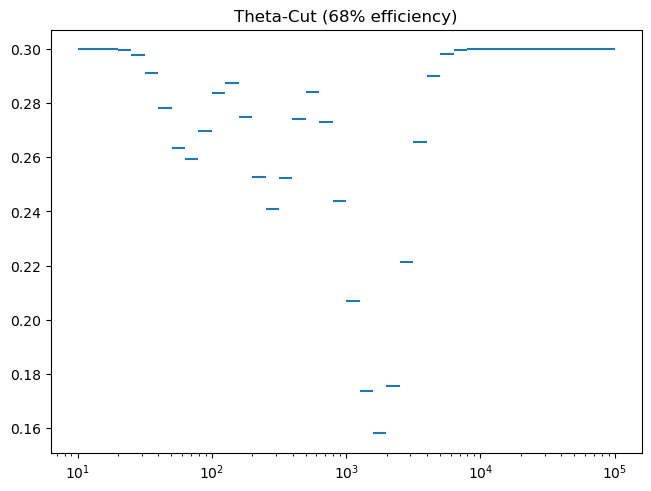

In [23]:
fig, ax = plt.subplots()

ax.errorbar(
    theta_cuts['center'].to_value(u.GeV),
    theta_cuts['cut'].to_value(u.deg),
    xerr=0.5 * (theta_cuts['high'] - theta_cuts['low']).to_value(u.GeV),
    ls='',
)

ax.set(
    xscale='log',
)
ax.set_title('Theta-Cut (68% efficiency)')

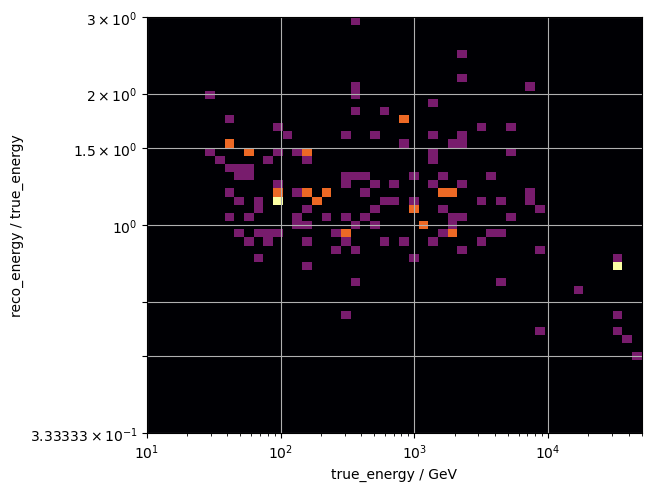

In [24]:
e_bins = np.geomspace(10 * u.GeV, 50 * u.TeV, 52)
mu_bins = np.geomspace(1/3, 3, 52)

fig, ax = plt.subplots(constrained_layout=True)

mask = selection & initial_gh_mask & theta_mask

gammas = particles["gammas"]["events"]
ax.hist2d(
    gammas['true_energy'][mask].to_value(u.GeV),
    (gammas['reco_energy'][mask] / gammas['true_energy'][mask]).to_value(u.one),
    bins=[e_bins.to_value(u.GeV), mu_bins],
    cmap='inferno',
)


ax.grid()
ax.set(
    xscale='log',
    yscale='log',
    xlabel='true_energy / GeV',
    ylabel='reco_energy / true_energy',
)
ax.set_yticks(np.array([1/3, 1/2, 2/3, 1.0, 3/2, 2/1, 3/1]))
ax.set_yticks([], minor=True)
None

In [25]:
mask = (
    selection
    & theta_mask
    & initial_gh_mask
)

np.count_nonzero([selection[selection], theta_mask[selection], initial_gh_mask[selection], mask[selection]], axis=1)

array([281, 245, 174, 151])

In [26]:
true_energy_bins = np.geomspace(10 * u.GeV, 100 * u.TeV, 21)

bias_resolution = QTable(energy_bias_resolution(
    gammas[mask],
    true_energy_bins,
    bias_function=np.mean
))

In [27]:
bias_resolution

true_energy_low,true_energy_high,true_energy_center,n_events,bias,resolution
TeV,TeV,TeV,,,
float64,float64,float64,int64,float64,float64
0.01,0.015848931924611134,0.012924465962305568,1,2.9651653595573864,0.0
0.015848931924611134,0.025118864315095794,0.020483898119853464,0,nan,nan
0.025118864315095794,0.039810717055349734,0.03246479068522276,3,0.6122984843608943,0.19238093686394586
0.039810717055349734,0.06309573444801933,0.05145322575168453,16,0.30079568993039807,0.23132116123464228
0.06309573444801933,0.1,0.08154786722400967,13,0.14341635149622067,0.1441788054913599
0.1,0.15848931924611143,0.1292446596230557,15,0.22384551563515143,0.22661596616844457
0.15848931924611143,0.25118864315095807,0.20483898119853475,7,0.10498904385960182,0.09209206488297071
0.25118864315095807,0.3981071705534973,0.32464790685222766,19,0.6473716003417255,0.5739399178823034


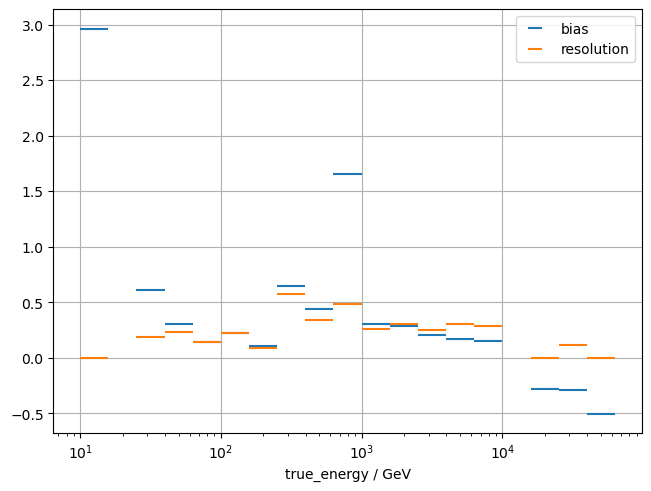

In [28]:
fig, ax = plt.subplots()


for key in ("bias", "resolution"):
    ax.errorbar(
        bias_resolution["true_energy_center"].to_value(u.GeV),
        bias_resolution[key],
        xerr=(bias_resolution["true_energy_high"] - bias_resolution["true_energy_low"]).to_value(u.GeV) / 2,
        ls='',
        label=key
    )

ax.set(
    xscale='log',
    xlabel='true_energy / GeV',
)
ax.legend()
ax.grid()

## Angular Resolution

In [29]:

bins = create_bins_per_decade(10 * u.GeV, 101 * u.TeV, 5)


fov_bins = [0, 1, 2, 3] * u.deg

resolutions = []
for inner, outer in zip(fov_bins[0:-1], fov_bins[1:]):
    
    selection = (
        gammas['valid_dl2'] 
        & (gammas['true_source_fov_offset'] >= inner)
        & (gammas['true_source_fov_offset'] < outer)
        & (gammas["multiplicity"] >= multiplicity_cut)
        & (initial_gh_mask)
    )

    resolutions.append(QTable(angular_resolution(
        gammas[selection],
        energy_bins=bins,
    )))

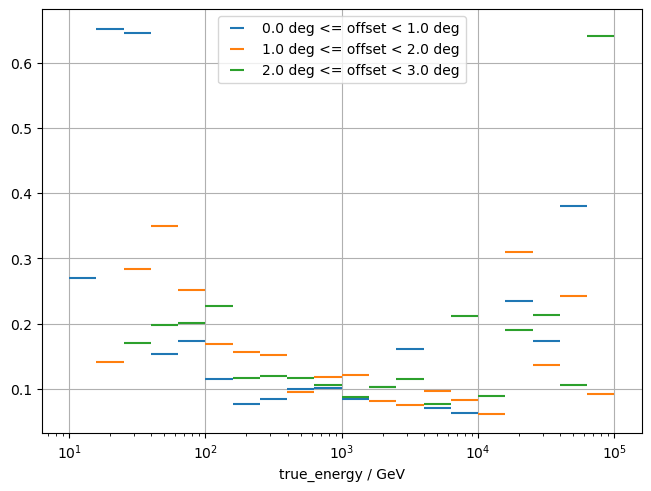

In [30]:
fig, ax = plt.subplots()


for ang_res, inner, outer in zip(resolutions, fov_bins[0:-1], fov_bins[1:]):

    ax.errorbar(
        ang_res["true_energy_center"].to_value(u.GeV),
        ang_res["angular_resolution_68"].to_value(u.deg),
        xerr=(ang_res["true_energy_high"] - ang_res["true_energy_low"]).to_value(u.GeV) / 2,
        ls='',
        label=f'{inner} <= offset < {outer}'
    )

ax.set(
    xscale='log',
    xlabel='true_energy / GeV',
)
ax.legend()
ax.grid()

## Sensivitity

In [31]:
for k, p in particles.items():
    p["events"]["selected_gh"] = evaluate_binned_cut(
        p["events"]["gh_score"],
        p["events"]["reco_energy"],
        initial_gh_cuts,
        op=operator.gt,
    )

In [32]:
np.seterr(invalid="ignore")

mask_signal = (
    (gammas["true_source_fov_offset"] >= fov_offset_min)
    & (gammas["true_source_fov_offset"] < fov_offset_max)
    & (gammas["multiplicity"] >= multiplicity_cut)
)



background = vstack([particles['protons']["events"], particles['electrons']['events']])
mask_background = (
    (background["multiplicity"] >= multiplicity_cut)
)


sensitivity, best_gh_cuts = optimize_gh_cut(
    signal=gammas[mask_signal],
    background=background[mask_background],
    reco_energy_bins=sensitivity_bins,
    gh_cut_efficiencies=np.arange(0.0, 1.0, 0.01),
    theta_cuts=theta_cuts,
    alpha=alpha,
    fov_offset_min=fov_offset_min,
    fov_offset_max=fov_offset_max,
)


sensitivity['flux'] = sensitivity['relative_sensitivity'] * CRAB_HEGRA(sensitivity['reco_energy_center'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 131.69it/s]


In [33]:
best_gh_cuts

low,center,high,cut
TeV,TeV,TeV,
float64,float64,float64,float64
0.012589254117941675,0.016270938633815235,0.0199526231496888,0.8953021811232107
0.0199526231496888,0.025787699875686295,0.03162277660168379,0.8953021811232107
0.03162277660168379,0.04087074998220551,0.05011872336272722,0.8953021811232107
0.05011872336272722,0.06477577341757768,0.07943282347242814,0.7426738332225872
0.07943282347242814,0.1026626823259224,0.12589254117941667,0.7047583220656244
0.12589254117941667,0.1627093863381523,0.1995262314968879,0.6912894010345342
0.1995262314968879,0.2578769987568628,0.3162277660168378,0.829402522126571
0.3162277660168378,0.4087074998220549,0.501187233627272,0.7296402059251075


In [34]:
magic_sensitivity = QTable.read('./magic_sensitivity_2014.ecsv')
magic_sensitivity['flux'] = magic_sensitivity['sensitivity_lima_5off']
magic_sensitivity['reco_energy_center'] = 0.5 * (magic_sensitivity['e_max'] + magic_sensitivity['e_min'])
magic_sensitivity['reco_energy_low'] = magic_sensitivity['e_min']
magic_sensitivity['reco_energy_high'] = magic_sensitivity['e_max']

In [35]:
cta_requirement = QTable.read('./cta_requirements_North-50h.dat', format="ascii.basic",
                             names=["reco_energy","flux"])

In [36]:
cta_requirement

reco_energy,flux
float64,float64
0.02512,4.327e-11
0.03162,2.03e-11
0.03981,1.167e-11
0.05012,7.418e-12
0.0631,4.935e-12
0.07943,3.367e-12
0.1,2.345e-12
0.1259,1.667e-12
0.1585,1.213e-12


### I can't find the prod5_sensitivity

```
prod5_sensitivity = QTable.read('./prod5_sensitivity.ecsv')
["angular_resolution"].to
prod5_sensitivity["reco_energy_center"] = 0.5 * (prod5_sensitivity["e_low"] + prod5_sensitivity["e_high"])
prod5_sensitivity["reco_energy_low"] = prod5_sensitivity["e_low"]
prod5_sensitivity["reco_energy_high"] = prod5_sensitivity["e_high"]
prod5_sensitivity["flux"] = (prod5_sensitivity["sensitivity"] / prod5_sensitivity["reco_energy_center"]**2).to(1 / (u.TeV * u.m**2 * u.s))
```

In [37]:
#prod5_sensitivity

In [38]:
sensitivity['flux'] = sensitivity['relative_sensitivity'] * CRAB_HEGRA(sensitivity['reco_energy_center'].to(u.TeV))
sensitivity

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity,flux
TeV,TeV,TeV,,,,,,,1 / (TeV s cm2)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.012589254117941675,0.0199526231496888,0.016270938633815235,nan,nan,0.0,0.0,nan,inf,inf
0.0199526231496888,0.03162277660168379,0.025787699875686295,nan,nan,0.0,0.0,nan,inf,inf
0.03162277660168379,0.05011872336272722,0.04087074998220551,nan,nan,0.0,0.0,nan,inf,inf
0.05011872336272722,0.07943282347242814,0.06477577341757768,0.0021732574362616306,10.0,0.0,0.0,5.986250026900071,0.0021732574362616306,7.998279549416554e-11
0.07943282347242814,0.12589254117941667,0.1026626823259224,0.08117667164114103,348.7827355370236,8.858144008478757,19603.81956915403,4.999999999999557,0.009019630182349005,9.932855923537107e-11
0.12589254117941667,0.1995262314968879,0.1627093863381523,0.14940726615018413,492.03024883129257,24.756659431620836,39399.36360659896,5.000000000001057,0.007470363307509206,2.4616546691880716e-11
0.1995262314968879,0.3162277660168378,0.2578769987568628,0.004912560738499794,10.0,0.0,0.0,5.986250026900071,0.002456280369249897,2.4219397894421897e-12
0.3162277660168378,0.501187233627272,0.4087074998220549,0.12024405693161884,224.4858414494695,12.245359881421415,7969.554371247187,5.000000000000137,0.0057259074729342305,1.6893892668300913e-12


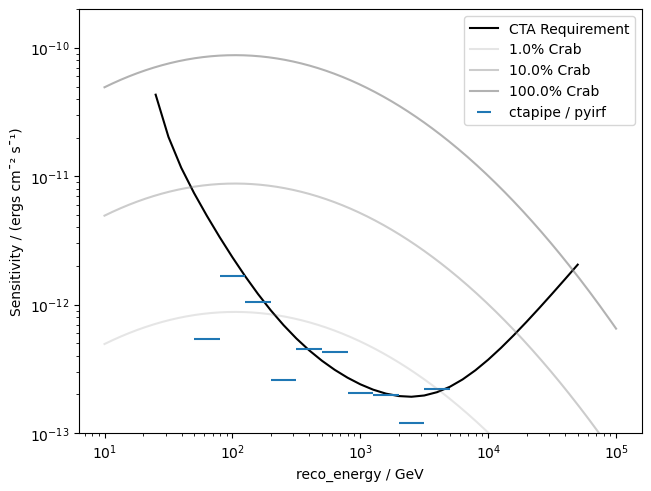

In [39]:
unit = (u.erg / u.cm**2 / u.s)

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(cta_requirement['reco_energy'] * 1e3, cta_requirement['flux'], color='k', label='CTA Requirement')



sensitivities = {
    "ctapipe / pyirf": sensitivity,
    #"MAGIC": magic_sensitivity,
    #"Prod5 Public (EventDisplay)": prod5_sensitivity,
}


for label, s in sensitivities.items():

    mask = np.isfinite(s['flux'])
    s = s[mask]
    
    xerr = [
        (s["reco_energy_center"] - s['reco_energy_low']).to_value(u.GeV),
        (s["reco_energy_high"] - s['reco_energy_center']).to_value(u.GeV)
    ]
    
    ax.errorbar(
        s['reco_energy_center'].to_value(u.GeV),
        (s['reco_energy_center']**2 * s['flux']).to_value(unit),
        xerr=xerr,
        ls='',
        label=label,
    )

e = np.geomspace(10 * u.GeV, 100 * u.TeV, 500)

for crab, alpha in zip((0.01, 0.1, 1), (0.2, 0.4, 0.6)):
    ax.plot(e.to_value(u.GeV), crab * (e**2 * CRAB_MAGIC_JHEAP2015(e)).to_value(unit), color='gray', alpha=alpha, label=f'{crab:.1%} Crab')


ax.legend()
ax.set(
    xscale='log',
    xlabel='reco_energy / GeV',
    ylabel='Sensitivity / (ergs cm¯² s¯¹)',
    ylim=(1e-13, 2e-10)
)
ax.set_yscale('log')

In [40]:
true_energy_bins = np.geomspace(10 * u.GeV, 100 * u.TeV, 26)

for name, p in particles.items():
    p['effective_areas'] = {}
    
    table = p['events']
    
    valid_mask = table['valid_dl2']
    prediction_mask = evaluate_binned_cut(
        table["gh_score"],
        table["reco_energy"],
        best_gh_cuts,
        op=operator.gt,
    )

    cut_mask = (
        valid_mask
        & prediction_mask
    )

    if name == 'gammas':
        theta_mask = evaluate_binned_cut(
            table["theta"],
            table["reco_energy"],
            theta_cuts,
            op=operator.lt,
        )
        cut_mask &= theta_mask


    
    masks = {
        'At Trigger': slice(None),
        'At DL2': valid_mask,
        f'After θ and gammaness cut' if name == 'gammas' else 'After gammaness cut': cut_mask,
        
    }

    for label, selection in masks.items():
        
        p['effective_areas'][label] = effective_area_per_energy_and_fov(
            table[selection],
            p["simulated_events"],
            true_energy_bins=true_energy_bins,
            fov_offset_bins=[0, 2] * u.deg,
        )[:, 0]

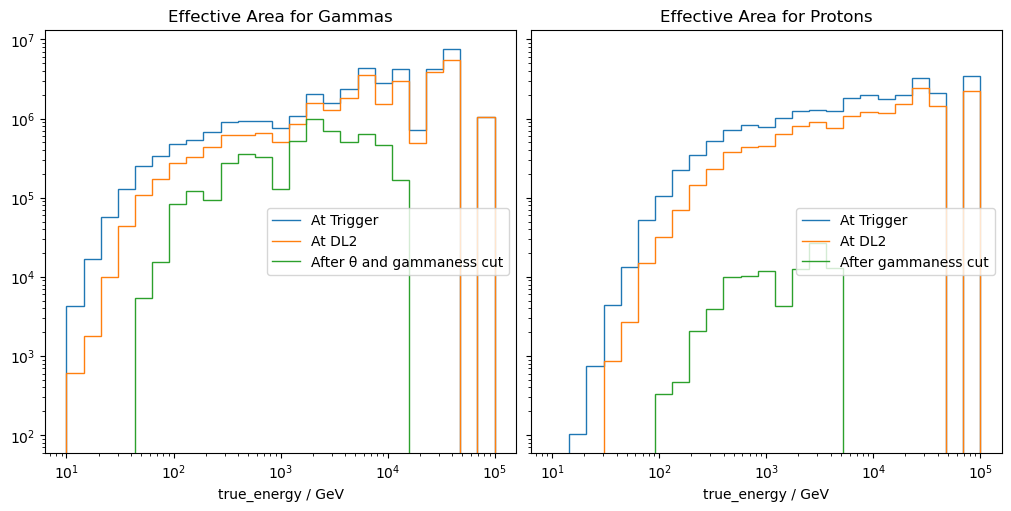

In [41]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, sharey=True, figsize=(10, 5))

for ax, (name, p) in zip(axs, particles.items()):
        
    ax.set_title(f'Effective Area for {name.title()}')
    
    for label, area in p['effective_areas'].items():
        ax.stairs(area.to_value(u.m**2), true_energy_bins.to_value(u.GeV), label=label)
        
    ax.legend(loc='center right')

    ax.set(
        xscale='log',
        yscale='log',
        xlabel='true_energy / GeV'
    )